    This file is a part of the lor_neuro_rat project.
    Copyright (C) 2019 anonimous

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

    Please contact with me by E-mail: shkolnick.kun@gmail.com

In [1]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import h5py

import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import gc
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate, Flatten
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
#from keras.layers import CuDNNLSTM, CuDNNGRU

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.callbacks import Callback
from keras import optimizers
from keras.layers import Lambda

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords

import os
#os.environ['OMP_NUM_THREADS'] = '4'

#from unidecode import unidecode

import time
%matplotlib inline

Using TensorFlow backend.


# Сформируем датасет

In [2]:
df = pd.read_pickle('data/XyWrdTok.pkl')

                   TopId             MsgId                    Creator  \
0  /forum/games/14782451  comment-14783955                              
1  /forum/games/14782451  comment-14783416     /people/Quasar/profile   
2  /forum/talks/14792750  comment-14796970        /people/dem/profile   
3  /forum/talks/14746691  comment-14748059  /people/Nastishka/profile   
4  /forum/talks/14708360  comment-14710855     /people/takino/profile   

                            Time                             SrcLink  \
0  2019-02-04T15:07:41.843+03:00                                       
1  2019-02-04T12:49:45.873+03:00  /forum/games/14782451?cid=14783405   
2  2019-02-09T21:48:25.312+03:00  /forum/talks/14792750?cid=14796966   
3  2019-01-20T01:02:29.181+03:00  /forum/talks/14746691?cid=14748036   
4  2019-01-03T07:58:00.200+03:00                                       

                                           DelReason  \
0  Сообщение удалено tailgunner по причине 5.3 На...   
1  Сообщение уда

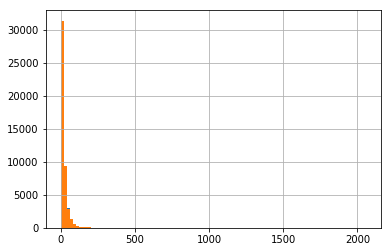

In [3]:
print(df.head())
print(df.describe())
df['TokCnt'].hist(bins=100)
df['WrdCnt'].hist(bins=100)

# Подготовка имбеддингов

In [4]:
y = df['Use'].values
X = [' '.join(tokens) for tokens in list(df['Tokens'])]

In [5]:
print(X[0])
print(X[1000])
print(y[0])
print(y[1000])

хохол хохол игрушка очень поэтому пофига
весь проснуться рая некоторый просто сдохнуть тм
1
0


In [106]:
#Приделываем токенайзер из keras
max_features = 100000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
print(len(tokenizer.word_index))

56287


In [107]:
wrds = []
idxs = []
for w, i in tokenizer.word_index.items():
    wrds.append(w)
    idxs.append(i)
    
if 'ебаный' in wrds:
    print(idxs[wrds.index('ебаный')])

33403


In [108]:
#Сохраняем токенайзер
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
#Грузим токенайзер
with open('models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [7]:
max_len = 200
X_seq = tokenizer.texts_to_sequences(X)
X_seq_pad = pad_sequences(X_seq, maxlen=max_len)

In [111]:
h5f = h5py.File('data/Xy.h5', 'w')
print(h5f.create_dataset('X_seq_pad', data=X_seq_pad))
print(h5f.create_dataset('y', data=y))
h5f.close()

<HDF5 dataset "X_seq_pad": shape (46391, 200), type "<i4">
<HDF5 dataset "y": shape (46391,), type "<i8">


In [8]:
h5f = h5py.File('data/Xy.h5', 'r')
X_seq_pad = h5f['X_seq_pad'][:]
y         = h5f['y'][:]
h5f.close()
print(X_seq_pad.shape)
print(y.shape)

(46391, 200)
(46391,)


In [115]:
#Вычисляем матрицу весов слоя имбеддингов
from pymagnitude import *
import gensim

mg = Magnitude('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.magnitude')
ft = gensim.models.fasttext.FastText.load('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model')

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words,300))

for word, i in word_index.items():
    #
    if i >= max_features: 
        continue
    #
    #embedding_matrix[i] = mg.query(word)
    try:
        embedding_matrix[i] = ft.wv[word]
    except:
        embedding_matrix[i] = mg.query(word)
    

56288


In [116]:
#Сохраняем матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'w')
print(h5f.create_dataset('EmbeddingMtx', data=embedding_matrix))
h5f.close()

<HDF5 dataset "EmbeddingMtx": shape (56288, 300), type "<f8">


In [9]:
#Грузим матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'r')
embedding_matrix = h5f['EmbeddingMtx'][:]
h5f.close()

In [10]:
print(mg.most_similar(embedding_matrix[41]))

NameError: name 'mg' is not defined

In [119]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, cv_iter=0, arch=0):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val, self.Weigths = validation_data
        self.max_score = 0
        self.not_better_count = 0
        self._cv_iter = cv_iter
        self._arch = arch

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1, batch_size=512)
            score = roc_auc_score(self.y_val, y_pred, sample_weight=self.Weigths)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
                model.save("models/best_model_%d_%d.h5"%(int(self._arch),int(self._cv_iter)))
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 3:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [122]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 0
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    #x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    #x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, max_pool])
    
    # Layer 6: output dense layer.
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [135]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 1
nn_arch = 1
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    #x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, max_pool])
    
    # Layer 6: output dense layer.
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [133]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 2
nn_arch = 2
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, max_pool])
    
    # Layer 6: output dense layer.
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [46]:
#Model 3
nn_arch = 3
def get_model(clipvalue=1.,num_filters=40,dropout=0.5,embed_size=300):
    inp = Input(shape=(max_len, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = Dense(num_filters, activation="relu")(x)
    
    x = Flatten()(x)
    # Layer 6: output dense layer.
    outp = Dense(1, activation="linear")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [137]:
print('Model:' , nn_arch)
model = get_model()

batch_size = 512

# Used epochs=100 with early exiting for best score.
epochs = 100
gc.collect()
K.clear_session()

# Change to 4
num_folds = 4 #number of folds

#Приводим типы
y = np.array(y)

#Веса примеров, "меняем местами" 1 и 0
w_0 = 1/np.sum((y == 0.0).astype('float'))
w_1 = 1/np.sum((y == 1.0).astype('float'))
w = w_0*(y == 0.0).astype('float') + w_1*(y == 1.0).astype('float')
w /= np.sum(w)
w *= len(y)

kf = KFold(n_splits=num_folds, shuffle=True, random_state=239)

i = 0
for train_index, test_index in kf.split(X):
    
    gc.collect()
    K.clear_session()
    
    y_train = y[train_index] 
    y_test  = y[test_index]
    
    X_train = X_seq_pad[train_index]
    X_test  = X_seq_pad[test_index]
    
    w_train = w[train_index]
    w_test  = w[test_index]
    
    model = get_model()
    
    ra_val = RocAucEvaluation(validation_data=(X_test, y_test, w_test), interval = 1, cv_iter=i, arch=nn_arch)
    
    model.fit(X_train, y_train, sample_weight=w_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = [ra_val])
    gc.collect()
    
    i += 1

print("Done")

Model: 1
Epoch 1/100
11598/11598 [==============================] - 3s 231us/step

 ROC-AUC - epoch: 1 - score: 0.728828 

*** New High Score (previous: 0.000000) 

Epoch 2/100
11598/11598 [==============================] - 3s 218us/step

 ROC-AUC - epoch: 2 - score: 0.763747 

*** New High Score (previous: 0.728828) 

Epoch 3/100
11598/11598 [==============================] - 3s 229us/step

 ROC-AUC - epoch: 3 - score: 0.790178 

*** New High Score (previous: 0.763747) 

Epoch 4/100
11598/11598 [==============================] - 3s 236us/step

 ROC-AUC - epoch: 4 - score: 0.801606 

*** New High Score (previous: 0.790178) 

Epoch 5/100
11598/11598 [==============================] - 3s 220us/step

 ROC-AUC - epoch: 5 - score: 0.806611 

*** New High Score (previous: 0.801606) 

Epoch 6/100
11598/11598 [==============================] - 3s 220us/step

 ROC-AUC - epoch: 6 - score: 0.809151 

*** New High Score (previous: 0.806611) 

Epoch 7/100
11598/11598 [==============================

Epoch 8/100
11598/11598 [==============================] - 3s 220us/step

 ROC-AUC - epoch: 8 - score: 0.844512 

*** New High Score (previous: 0.842327) 

Epoch 9/100
11598/11598 [==============================] - 3s 222us/step

 ROC-AUC - epoch: 9 - score: 0.846549 

*** New High Score (previous: 0.844512) 

Epoch 10/100
11598/11598 [==============================] - 3s 220us/step

 ROC-AUC - epoch: 10 - score: 0.846326 

Epoch 11/100
11598/11598 [==============================] - 3s 221us/step

 ROC-AUC - epoch: 11 - score: 0.847741 

*** New High Score (previous: 0.846549) 

Epoch 12/100
11598/11598 [==============================] - 3s 221us/step

 ROC-AUC - epoch: 12 - score: 0.849644 

*** New High Score (previous: 0.847741) 

Epoch 13/100
11598/11598 [==============================] - 3s 221us/step

 ROC-AUC - epoch: 13 - score: 0.847996 

Epoch 14/100
11598/11598 [==============================] - 3s 221us/step

 ROC-AUC - epoch: 14 - score: 0.843663 

Epoch 15/100
11598/11598

In [78]:
y_all = load_model('models/best_model_1_0.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_1_1.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all += load_model('models/best_model_1_2.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all += load_model('models/best_model_1_3.h5').predict(X_seq_pad, verbose=1, batch_size=512)
y_all /= 3.0#2.0*np.average(y_all)

46391/46391 [==============================] - 14s 295us/step


In [117]:
#y_t = (y_all>1.0*np.average(y_all)).astype('float').reshape(y.shape)
y_t = (y_all>0.8).astype('float').reshape(y.shape)

#print('==== Weghtted scores ====')
#print('   Acc:', accuracy_score(y, y_t, sample_weight=w))
#print('  Prec:', precision_score(y, y_t, sample_weight=w))
#print('Recall:', recall_score(y, y_t, sample_weight=w))
#print('    F1:', f1_score(y, y_t, sample_weight=w))
#print('RocAuc:', roc_auc_score(y, y_t, sample_weight=w))

print('==== Scores ====')
print('   Acc:', accuracy_score(y, y_t))
print('  Prec:', precision_score(y, y_t))
print('Recall:', recall_score(y, y_t))
print('    F1:', f1_score(y, y_t))
print('RocAuc:', roc_auc_score(y, y_t))

print('================')
print('FP:', np.sum((y_t != y).astype('float')*y_t))
print('FN:', np.sum((y_t != y).astype('float')*y))
print('TP:', np.sum((y_t == y).astype('float')*y_t))
print('TN:', np.sum((y_t == y).astype('float')*(1-y)))
print('N: ', len(X))

==== Scores ====
   Acc: 0.9662650082990235
  Prec: 0.15826330532212884
Recall: 0.3837011884550085
    F1: 0.22409519087754093
RocAuc: 0.6787288964850476
FP: 1202.0
FN: 363.0
TP: 226.0
TN: 44600.0
N:  46391


In [110]:
df.describe()

,Score,Class,Use,WrdCnt,TokCnt,FN,FP
count,46391.000000,46391.000000,46391.000000,46391.000000,46391.000000,46391.000000,46391.000000
mean,-0.039318,0.170637,0.012696,21.470285,21.396844,0.012524,0.000237
std,0.518805,1.543905,0.111962,32.077247,31.949034,0.111209,0.015397
min,-20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,7.000000,7.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,13.000000,13.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,25.000000,25.000000,0.000000,0.000000
max,0.000000,17.000000,1.000000,2053.000000,2050.000000,1.000000,1.000000


In [111]:
df['FN'] = y*(y_t != y).astype('float')
df['FP'] = y_t*(y_t != y).astype('float')

In [112]:
df_fp = df[df['FP'] == 1.0]

In [113]:
df_fp.describe()

,Score,Class,Use,WrdCnt,TokCnt,FN,FP
count,1202.0,1202.0,1202.0,1202.000000,1202.000000,1202.0,1202.0
mean,0.0,0.0,0.0,20.122296,19.948419,0.0,1.0
std,0.0,0.0,0.0,27.058869,26.798828,0.0,0.0
min,0.0,0.0,0.0,1.000000,1.000000,0.0,1.0
25%,0.0,0.0,0.0,6.000000,6.000000,0.0,1.0
50%,0.0,0.0,0.0,12.000000,12.000000,0.0,1.0
75%,0.0,0.0,0.0,23.000000,23.000000,0.0,1.0
max,0.0,0.0,0.0,336.000000,338.000000,0.0,1.0


In [114]:
df_fp.to_pickle('data/Xy_fp.pkl')
df_fp.to_excel('data/Xy_fp.xlsx')

In [115]:
df_fn = df[df['FN'] == 1.0]

In [116]:
df_fn.to_pickle('data/Xy_fn.pkl')
df_fn.to_excel('data/Xy_fn.xlsx')